In [69]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from fastai.text.all import *
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from gensim import models
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

[nltk_data] Downloading package stopwords to /home/madao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/madao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/madao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
from keras.initializers import glorot_uniform
import tensorflow as tf

In [60]:
#Reading the model from JSON file
with open('model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights('model.h5')
model_j.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 65, 300)      6381300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 64, 200)      120200      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 63, 200)      180200      embedding[0][0]                  
______________________________________________________________________________________________

In [70]:
# Use fastai to handle text preprocessing and tokenization
from fastai.text.all import *
path = Path(f'{os.getcwd()}/../datasets/')

In [71]:
tweets_covid_all_vaccination = pd.read_csv(path/'tweets_covid_all_vaccination.csv')
tweets_extraction = pd.read_csv(path/'tweets_extraction.csv')

In [72]:
tweets_covid_all_vaccination.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [73]:
tweets_extraction.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."


In [74]:
# Remove Emojis Helper
def remove_emojis(str):
    return str.encode('ascii', 'ignore').decode('ascii')

# Remove URLs, Hashtags, handles, and Emojis
def remove(ts, idx='text'):
    ts['orig_text'] = ts[idx]
    ts[idx] = ts[idx].apply(lambda x:re.sub('@[^\s]+','',x))
    ts[idx] = ts[idx].apply(lambda x:re.sub(r"http\S+", "", x))
    ts[idx] = ts[idx].apply(remove_emojis)
    ts[idx] = ts[idx].apply(lambda x:re.sub(r'\B#\S+','',x))
    return ts[ts[idx]!='']

tweets_covid_all_vaccination['sentiment'] = np.nan
tweets_covid_all_vaccination = remove(tweets_covid_all_vaccination)
tweets_extraction = tweets_extraction[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
tweets_extraction = remove(tweets_extraction)
tweets_merge = tweets_extraction[['text', 'sentiment']].append(tweets_covid_all_vaccination[['text', 'sentiment']])
tweets = tweets_merge.dropna(subset=['sentiment'])

In [75]:
tweets_covid_all_vaccination.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,orig_text
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0,False,NaN,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1,False,NaN,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,NaN,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i",NaN,Twitter Web App,446,2129,False,NaN,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4"
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NaN,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq


In [40]:
tweets

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,negative
...,...,...
39994,Succesfully following Tayla!!,positive
39996,Happy Mothers Day All my love,positive
39997,"Happy Mother's Day to all the mommies out there, be you woman or man as long as you're 'momma' to someone this is your day!",positive
39998,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!,neutral


In [41]:
tweets['sentiment'] = tweets['sentiment'].apply(lambda x: np.where(tweets['sentiment'].unique()== x )[0][0])

/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
all_text_tokens = []
for sentence in tweets["text"]:
    content_token = nltk.word_tokenize(sentence)

    lower_token = []
    for token in content_token:
        lower_token.append(token.lower())

    punctuation_token = []
    for token in lower_token:
        punctuation_token.append(re.sub(r'[^\w\s]+', '', token))

    small_token = []
    for token in punctuation_token:
        if len(token)>1:
            small_token.append(token)

    stop_token = []
    for token in small_token:
        if token not in stopwords_list:
            stop_token.append(token)

    lemmatization_token = []
    for token in stop_token:
        lemmatization_token.append(WordNetLemmatizer().lemmatize(token))

    stemming_token = []
    for token in lemmatization_token:
        stemming_token.append(PorterStemmer().stem(token))
    
    all_text_tokens.append(stemming_token)
print(all_text_tokens[:10])

[['layin', 'bed', 'headach', 'ughhhh', 'waitin', 'call'], ['funer', 'ceremoni', 'gloomi', 'friday'], ['want', 'hang', 'friend', 'soon'], ['want', 'trade', 'someon', 'houston', 'ticket', 'one'], ['reping', 'nt', 'go', 'prom', 'bc', 'bf', 'nt', 'like', 'friend'], ['hmmm'], ['charlen', 'love', 'miss'], ['sorri', 'least', 'friday'], ['cant', 'fall', 'asleep'], ['choke', 'retain']]


In [44]:
tweets['text_final'] = [' '.join(text) for text in all_text_tokens]
tweets['text_tokens'] = all_text_tokens
tweets

/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,sentiment,text_final,text_tokens
1,Layin n bed with a headache ughhhh...waitin on your call...,0,layin bed headach ughhhh waitin call,"[layin, bed, headach, ughhhh, waitin, call]"
2,Funeral ceremony...gloomy friday...,0,funer ceremoni gloomi friday,"[funer, ceremoni, gloomi, friday]"
3,wants to hang out with friends SOON!,1,want hang friend soon,"[want, hang, friend, soon]"
4,"We want to trade with someone who has Houston tickets, but no one will.",2,want trade someon houston ticket one,"[want, trade, someon, houston, ticket, one]"
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,0,reping nt go prom bc bf nt like friend,"[reping, nt, go, prom, bc, bf, nt, like, friend]"
...,...,...,...,...
39994,Succesfully following Tayla!!,1,succes follow tayla,"[succes, follow, tayla]"
39996,Happy Mothers Day All my love,1,happi mother day love,"[happi, mother, day, love]"
39997,"Happy Mother's Day to all the mommies out there, be you woman or man as long as you're 'momma' to someone this is your day!",1,happi mother day mommi woman man long momma someon day,"[happi, mother, day, mommi, woman, man, long, momma, someon, day]"
39998,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!,2,wassup beauti follow peep new hit singl wwwmyspacecomipsohot def wat video,"[wassup, beauti, follow, peep, new, hit, singl, wwwmyspacecomipsohot, def, wat, video]"


In [45]:
neg = []
pos = []
netrl = []

for senti in tweets['sentiment']:
    # negative
    if senti == 0:
        neg.append(1)
        pos.append(0)
        netrl.append(0)
    # positive
    elif senti == 1:
        neg.append(0)
        pos.append(1)
        netrl.append(0)    
    # neutral
    else:
        neg.append(0)
        pos.append(0)
        netrl.append(1)
        
tweets['neg']= neg
tweets['pos']= pos
tweets['netrl'] = netrl
tweets

/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,text,sentiment,text_final,text_tokens,neg,pos,netrl
1,Layin n bed with a headache ughhhh...waitin on your call...,0,layin bed headach ughhhh waitin call,"[layin, bed, headach, ughhhh, waitin, call]",1,0,0
2,Funeral ceremony...gloomy friday...,0,funer ceremoni gloomi friday,"[funer, ceremoni, gloomi, friday]",1,0,0
3,wants to hang out with friends SOON!,1,want hang friend soon,"[want, hang, friend, soon]",0,1,0
4,"We want to trade with someone who has Houston tickets, but no one will.",2,want trade someon houston ticket one,"[want, trade, someon, houston, ticket, one]",0,0,1
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,0,reping nt go prom bc bf nt like friend,"[reping, nt, go, prom, bc, bf, nt, like, friend]",1,0,0
...,...,...,...,...,...,...,...
39994,Succesfully following Tayla!!,1,succes follow tayla,"[succes, follow, tayla]",0,1,0
39996,Happy Mothers Day All my love,1,happi mother day love,"[happi, mother, day, love]",0,1,0
39997,"Happy Mother's Day to all the mommies out there, be you woman or man as long as you're 'momma' to someone this is your day!",1,happi mother day mommi woman man long momma someon day,"[happi, mother, day, mommi, woman, man, long, momma, someon, day]",0,1,0
39998,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!,2,wassup beauti follow peep new hit singl wwwmyspacecomipsohot def wat video,"[wassup, beauti, follow, peep, new, hit, singl, wwwmyspacecomipsohot, def, wat, video]",0,0,1


In [46]:
data = tweets[['text_final', 'text_tokens', 'sentiment', 'neg', 'pos', 'netrl']]
data.head()

,text_final,text_tokens,sentiment,neg,pos,netrl
1,layin bed headach ughhhh waitin call,"[layin, bed, headach, ughhhh, waitin, call]",0,1,0,0
2,funer ceremoni gloomi friday,"[funer, ceremoni, gloomi, friday]",0,1,0,0
3,want hang friend soon,"[want, hang, friend, soon]",1,0,1,0
4,want trade someon houston ticket one,"[want, trade, someon, houston, ticket, one]",2,0,0,1
5,reping nt go prom bc bf nt like friend,"[reping, nt, go, prom, bc, bf, nt, like, friend]",0,1,0,0


In [47]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['text_tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [48]:
word2vec = models.KeyedVectors.load_word2vec_format('/home/madao/CS410/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [49]:
train_embeddings = get_word2vec_embeddings(word2vec, data, generate_missing=True)

In [53]:
# Reference: https://notebook.community/rahulavadhoot/Portfolio/projects/natural%20language%20processing/Disasters%20on%20social%20media/Disasters%20on%20social%20media
train_words = [word for tokens in data["text_tokens"] for word in tokens]
train_vocs = sorted(list(set(train_words)))
print(str(len(train_words)) + " train words")
print(str(len(train_vocs)) + " train vocabularies")

223166 train words
21290 train vocabularies


In [55]:
from keras.preprocessing.text import Tokenizer
text_final_list = data["text_final"].tolist()
tokenizer = Tokenizer(num_words=len(train_vocs), char_level=False)
tokenizer.fit_on_texts(text_final_list)
train_sequences = tokenizer.texts_to_sequences(text_final_list)
train_tokens = tokenizer.word_index
print(str(len(train_tokens)) + " unique tokens after vectorization")

21270 unique tokens after vectorization


In [56]:
MAX_SEQUENCE_LENGTH = 65
EMBEDDING_DIM = 300

In [57]:
train_cnn_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [58]:
train_embedding_weights = np.zeros((len(train_tokens)+1, EMBEDDING_DIM))
for word,index in train_tokens.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(21271, 300)


In [59]:
y_train = data[['neg', 'pos', 'netrl']].values

In [76]:
tweets_covid_all_vaccination.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,orig_text
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0,False,NaN,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1,False,NaN,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,NaN,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i",NaN,Twitter Web App,446,2129,False,NaN,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4"
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NaN,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq


In [79]:
test_text = tweets_covid_all_vaccination[['text']]

In [82]:
all_text_tokens = []
for sentence in test_text["text"]:
    content_token = nltk.word_tokenize(sentence)

    lower_token = []
    for token in content_token:
        lower_token.append(token.lower())

    punctuation_token = []
    for token in lower_token:
        punctuation_token.append(re.sub(r'[^\w\s]+', '', token))

    small_token = []
    for token in punctuation_token:
        if len(token)>1:
            small_token.append(token)

    stop_token = []
    for token in small_token:
        if token not in stopwords_list:
            stop_token.append(token)

    lemmatization_token = []
    for token in stop_token:
        lemmatization_token.append(WordNetLemmatizer().lemmatize(token))

    stemming_token = []
    for token in lemmatization_token:
        stemming_token.append(PorterStemmer().stem(token))
    
    all_text_tokens.append(stemming_token)
print(all_text_tokens[:10])

[['folk', 'said', 'daikon', 'past', 'could', 'treat', 'cytokin', 'storm'], ['world', 'wrong', 'side', 'histori', 'year', 'hope', 'biggest', 'vaccin', 'effort', 'ev'], ['russian', 'vaccin', 'creat', 'last', '24', 'year'], ['fact', 'immut', 'senat', 'even', 'ethic', 'sturdi', 'enough', 'acknowledg', 'born'], ['explain', 'need', 'vaccin'], ['anyon', 'use', 'adviceguid', 'whether', 'covid', 'vaccin', 'safe', 'whilst', 'breastfeed'], ['bit', 'sad', 'claim', 'fame', 'success', 'patriot', 'competit', 'usa', 'canada', 'uk'], ['mani', 'bright', 'day', '2020', 'best', 'win'], ['covid', 'vaccin', 'get'], ['state', 'start', 'get', 'monday', 'say']]


In [83]:
test_text['text_final'] = [' '.join(text) for text in all_text_tokens]
test_text['text_tokens'] = all_text_tokens
test_text

/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/madao/anaconda3/envs/CS410/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,text_final,text_tokens
0,Same folks said daikon paste could treat a cytokine storm,folk said daikon past could treat cytokin storm,"[folk, said, daikon, past, could, treat, cytokin, storm]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",world wrong side histori year hope biggest vaccin effort ev,"[world, wrong, side, histori, year, hope, biggest, vaccin, effort, ev]"
2,Russian vaccine is created to last 2-4 years,russian vaccin creat last 24 year,"[russian, vaccin, creat, last, 24, year]"
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i",fact immut senat even ethic sturdi enough acknowledg born,"[fact, immut, senat, even, ethic, sturdi, enough, acknowledg, born]"
4,Explain to me again why we need a vaccine,explain need vaccin,"[explain, need, vaccin]"
...,...,...,...
29442,failed !!,fail,[fail]
29443,Why is not trying to get and why is not asking him about it?\nThere's,tri get ask,"[tri, get, ask]"
29444,"has never mentioned not once, and that in a country with severe vax shortage, how is tha",never mention countri sever vax shortag tha,"[never, mention, countri, sever, vax, shortag, tha]"
29445,"is safe, cheap and efficacious, and if is up to you will never get it.",safe cheap efficaci never get,"[safe, cheap, efficaci, never, get]"


In [84]:
test_embeddings = get_word2vec_embeddings(word2vec, test_text, generate_missing=True)

In [87]:
test_words = [word for tokens in test_text["text_tokens"] for word in tokens]
test_vocs = sorted(list(set(test_words)))

In [105]:
print(str(len(test_words)) + " train words")
print(str(len(test_vocs)) + " train vocabularies")

230099 train words
15939 train vocabularies


In [106]:
from keras.preprocessing.text import Tokenizer
text_final_list = test_text["text_final"].tolist()
tokenizer = Tokenizer(num_words=len(test_vocs), char_level=False)
tokenizer.fit_on_texts(text_final_list)
test_sequences = tokenizer.texts_to_sequences(text_final_list)
test_tokens = tokenizer.word_index
print(str(len(test_tokens)) + " unique tokens after vectorization")

15933 unique tokens after vectorization


In [101]:
MAX_SEQUENCE_LENGTH = 65
EMBEDDING_DIM = 300

In [102]:
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [103]:
result = model_j.predict(test_cnn_data)

In [109]:
print(list(np.argmax(result,axis=1)))

[2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 

In [111]:
print(len(result))

29447


In [113]:
tweets_covid_all_vaccination.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,orig_text
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0,False,NaN,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1,False,NaN,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,NaN,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i",NaN,Twitter Web App,446,2129,False,NaN,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4"
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NaN,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq


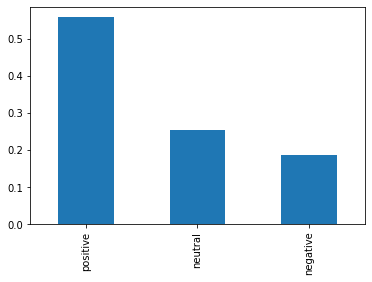

In [121]:
tweets_covid_all_vaccination['sentiment'] = np.argmax(result,axis=1)
tweets_covid_all_vaccination['sentiment'] = tweets_covid_all_vaccination['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Convert dates
tweets_covid_all_vaccination['date'] = pd.to_datetime(tweets_covid_all_vaccination['date'], errors='coerce').dt.date

# Save to csv
# tweets_covid_all_vaccination.to_csv('vax_tweets_sentiment.csv')

# Plot sentiment value counts
tweets_covid_all_vaccination['sentiment'].value_counts(normalize=True).plot.bar();

In [122]:
timeline = tweets_covid_all_vaccination.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

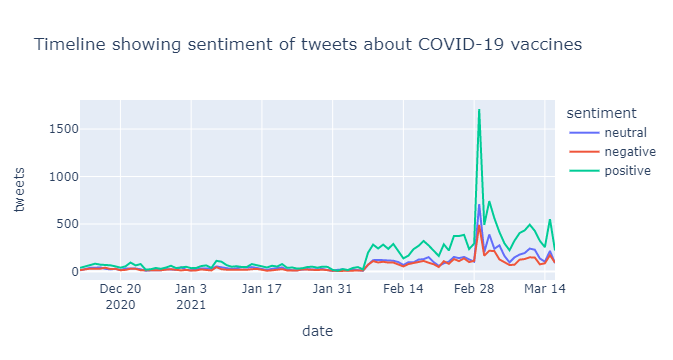

In [123]:
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [124]:
import datetime
import os
import time
with os.scandir(".") as dir_entries:
    for entry in dir_entries:
        unix_timestamp  = int(entry.stat().st_mtime)
        utc_time = time.gmtime(unix_timestamp)
        print(f"Dataset last time updated: {utc_time.tm_year}-{utc_time.tm_mon}-{utc_time.tm_mday}")
        break
        
ldt = datetime.datetime.now()
print(f"Noteboook last time updated: {ldt.year}-{ldt.month}-{ldt.day}")

Dataset last time updated: 2021-12-6
Noteboook last time updated: 2021-12-6


In [125]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

In [126]:
data_df = pd.read_csv("../vaccination_datasets/country_vaccinations.csv")
country_vaccine = data_df.groupby(["country", "iso_code", "vaccines"])['total_vaccinations', 
                                                                       'total_vaccinations_per_hundred',
                                                                      'daily_vaccinations',
                                                                      'daily_vaccinations_per_million',
                                                                      'people_vaccinated',
                                                                      'people_vaccinated_per_hundred',
                                                                       'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred'
                                                                      ].max().reset_index()
country_vaccine.columns = ["Country", "iso_code", "Vaccines", "Total vaccinations", "Percent", "Daily vaccinations", 
                           "Daily vaccinations per million", "People vaccinated", "People vaccinated per hundred",
                           'People fully vaccinated', 'People fully vaccinated percent']

In [127]:
country_vaccine_time = data_df[["country", "vaccines", "date", 'total_vaccinations', 
                                'total_vaccinations_per_hundred',  'people_vaccinated','people_vaccinated_per_hundred',
                               'daily_vaccinations','daily_vaccinations_per_million', 
                                'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred'
                               ]].dropna()
country_vaccine_time.columns = ["Country", "Vaccines", "Date", 'Total vaccinations', 'Percent', 'People vaccinated', 'People percent',
                               "Daily vaccinations", "Daily vaccinations per million", 
                                'People fully vaccinated', 'People fully vaccinated percent']

In [129]:
countries = ['Austria', 'Belgium', 'Bulgaria','Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
             'Greece', 'Hungary', 'Ireland', 'Israel', 'Italy', 'Latvia','Lithuania', 'Luxembourg', 'Malta',
             'Netherlands', 'Norway','Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Spain', 'Sweden',
             'United Kingdom', 'United States', 'China']

In [131]:
def plot_vaccine_progress(df, countries, feature, title):
    data = []
    dates = df['Date'].sort_values()
    dates_list = dates.tolist()
    dates_list = [dates_list[i] for i in range(0, len(dates_list), 100)]
    for date in dates_list:
        x = []
        y = []
        for country in countries:
            x.append(country)
            if not df.loc[(df.Country==country) & (df.Date==date)].empty:
                y.append(df.loc[(df.Country==country) & (df.Date==date)][feature].values[0])
            else:
                y.append(0)
        data.append({'type': 'bar','x': x,'y': y, 'visible': False})
    data[0]['visible'] = True
    steps = []
    for i in range(len(dates_list)):
        step = dict(
           method = 'restyle',
           args = ['visible', [False] * len(dates_list)],
            label='Date {}'.format(dates_list[i]),
        )
        step['args'][1][i] = True
        steps.append(step)
    sliders = [dict(
        active = 0,
        pad = {"t": 50},
        steps = steps
    )]
    layout = dict(sliders=sliders, height=800, title=title)
    fig = dict(data=data, layout=layout)

    iplot(fig)

In [137]:
country_vaccine_time.head()

,Country,Vaccines,Date,Total vaccinations,Percent,People vaccinated,People percent,Daily vaccinations,Daily vaccinations per million,People fully vaccinated,People fully vaccinated percent
78,Afghanistan,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-11,504502.0,1.30,448878.0,1.15,13921.0,358.0,55624.0,0.14
87,Afghanistan,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-20,547901.0,1.41,470341.0,1.21,4822.0,124.0,77560.0,0.20
91,Afghanistan,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-24,573277.0,1.47,476367.0,1.22,5692.0,146.0,96910.0,0.25
93,Afghanistan,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-26,590454.0,1.52,479372.0,1.23,6768.0,174.0,111082.0,0.29
94,Afghanistan,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-27,593313.0,1.52,479574.0,1.23,6487.0,167.0,113739.0,0.29


In [173]:
new_country_vaccine = country_vaccine_time[country_vaccine_time['Country']=='United States'][['Date', 'Percent', 'Country']]

In [174]:
new_country_vaccine.head()

,Date,Percent,Country
24789,2021-01-14,3.33,United States
24790,2021-01-15,3.67,United States
24794,2021-01-19,4.70,United States
24795,2021-01-20,4.94,United States
24796,2021-01-21,5.25,United States


In [165]:
timeline = tweets_covid_all_vaccination.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

,date,sentiment,tweets
0,2020-12-12,negative,14
1,2020-12-12,neutral,11
2,2020-12-12,positive,38
3,2020-12-13,negative,22
4,2020-12-13,neutral,22


In [169]:
timeline.head()

,date,sentiment,tweets
120,2021-01-21,negative,25
121,2021-01-21,neutral,42
122,2021-01-21,positive,78
123,2021-01-22,negative,11
124,2021-01-22,neutral,16


In [167]:
timeline = timeline[(timeline['date'] > datetime.date(year=2021,month=1,day=20)) & (timeline['date'] < datetime.date(year=2021,month=3,day=16))]

In [175]:
new_country_vaccine['Date'] = pd.to_datetime(new_country_vaccine['Date']).dt.date

In [172]:
new_country_vaccine.head()

,Date,Percent,Country
24789,2021-01-14,3.33,United States
24790,2021-01-15,3.67,United States
24794,2021-01-19,4.70,United States
24795,2021-01-20,4.94,United States
24796,2021-01-21,5.25,United States


In [176]:
new_country_vaccine = new_country_vaccine[(new_country_vaccine['Date'] > datetime.date(year=2021,month=1,day=20)) & (new_country_vaccine['Date'] < datetime.date(year=2021,month=3,day=16))]

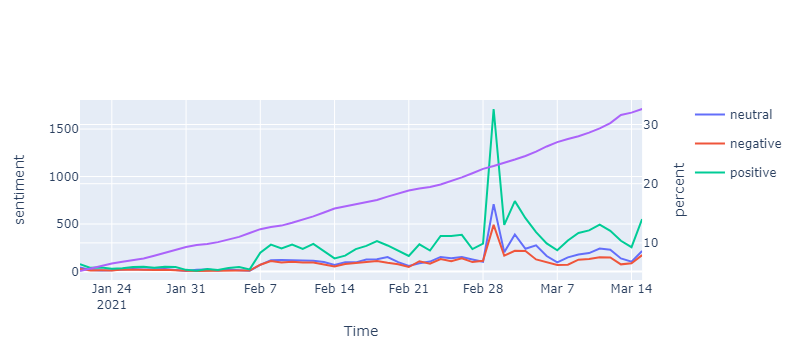

In [178]:
# import some stuff
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# # create some data
# df = pd.DataFrame()
# n = 50
# df["Time"] = np.arange(n)
# df["Linear-"] = np.arange(n)+np.random.rand(n)
# df["Linear+"] = np.arange(n)+np.random.rand(n)
# df["Log-"] = np.arange(n)+np.random.rand(n)
# df["Log+"] = np.arange(n)+np.random.rand(n)
# df.set_index("Time", inplace=True)

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig2 = px.line(new_country_vaccine, x='Date', y='Percent')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="sentiment"
subfig.layout.yaxis2.title="percent"
# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

In [182]:
country_vaccine_time.columns

Index(['Country', 'Vaccines', 'Date', 'Total vaccinations', 'Percent',
       'People vaccinated', 'People percent', 'Daily vaccinations',
       'Daily vaccinations per million', 'People fully vaccinated',
       'People fully vaccinated percent'],
      dtype='object')

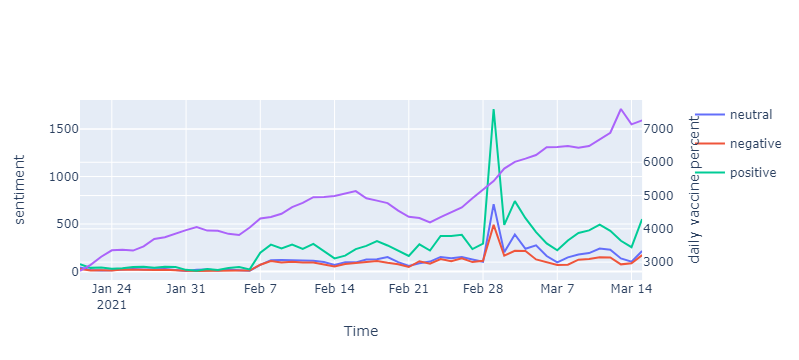

In [193]:
new_country_vaccine_daily_percent = country_vaccine_time[country_vaccine_time['Country']=='United States'][['Date', 'Daily vaccinations per million', 'Country']]
new_country_vaccine_daily_percent['Date'] = pd.to_datetime(new_country_vaccine_daily_percent['Date']).dt.date
new_country_vaccine_daily_percent = new_country_vaccine_daily_percent[(new_country_vaccine_daily_percent['Date'] > datetime.date(year=2021,month=1,day=20)) & (new_country_vaccine_daily_percent['Date'] < datetime.date(year=2021,month=3,day=16))]

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig2 = px.line(new_country_vaccine_daily_percent, x='Date', y='Daily vaccinations per million')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="sentiment"
subfig.layout.yaxis2.title="daily vaccine percent"
# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

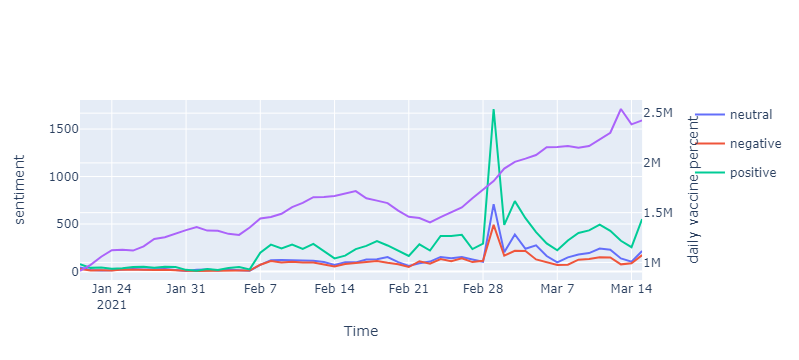

In [189]:
new_country_vaccine_daily = country_vaccine_time[country_vaccine_time['Country']=='United States'][['Date', 'Daily vaccinations', 'Country']]
new_country_vaccine_daily['Date'] = pd.to_datetime(new_country_vaccine_daily['Date']).dt.date
new_country_vaccine_daily = new_country_vaccine_daily[(new_country_vaccine_daily['Date'] > datetime.date(year=2021,month=1,day=20)) & (new_country_vaccine_daily['Date'] < datetime.date(year=2021,month=3,day=16))]

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig2 = px.line(new_country_vaccine_daily, x='Date', y='Daily vaccinations')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="sentiment"
subfig.layout.yaxis2.title="daily vaccine percent"
# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

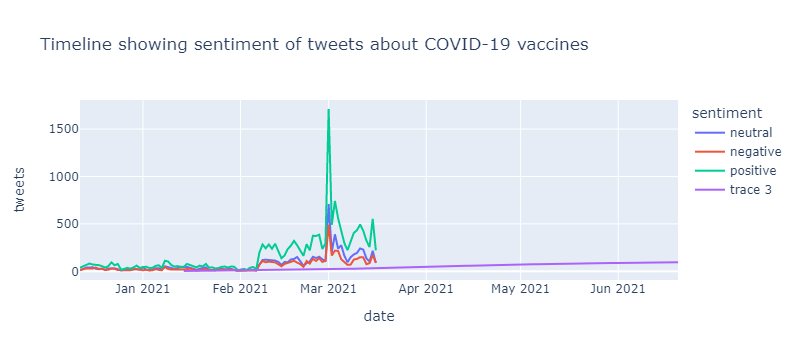

In [145]:
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
# px.line(new_country_vaccine, x='Date', y='Percent')
fig.add_scatter(x=new_country_vaccine['Date'], y=new_country_vaccine['Percent'], mode='lines')
fig.show()

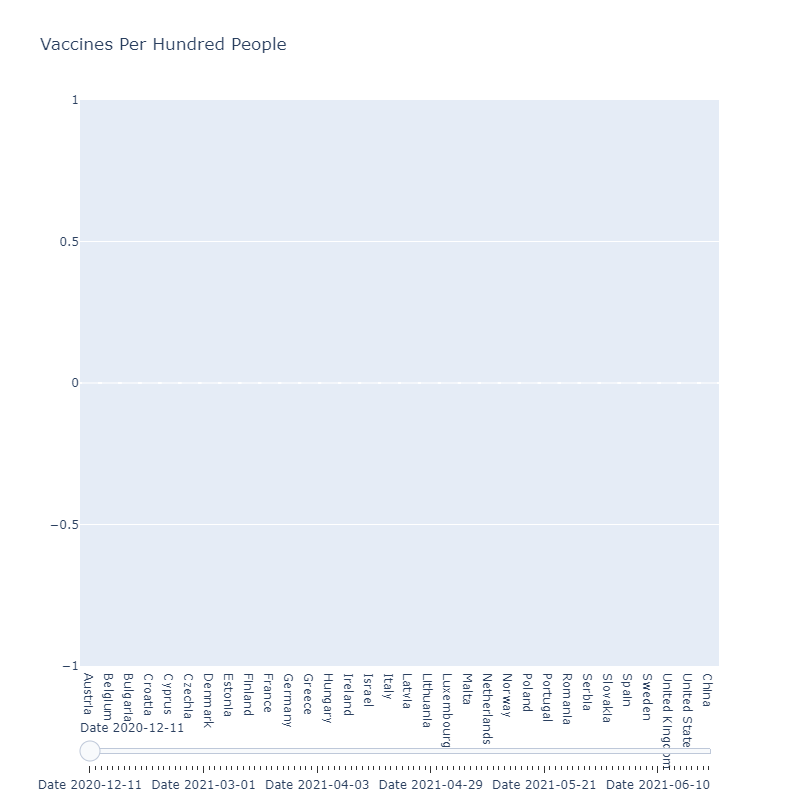

In [132]:
plot_vaccine_progress(country_vaccine_time, countries, 'Percent', 'Vaccines Per Hundred People')